In [1]:
!nvidia-smi

Tue Dec  2 03:30:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q transformers datasets accelerate pillow matplotlib

In [3]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

- `Blip2Processor` : image + text를 model을 위한 tensor 형태로 들어가게 해주는 전처리
  - 안에 image resize + regularization + tokenizer가 같이 들어 있음
- `Blip2ForConditionalGeneration`: BLIP-2 VLM 본체
  - image + text input을 받아서 text 생성하는 모델

In [4]:
class MLLMWrapper:

    def __init__(
        self,
        model_name: str = "Salesforce/blip2-opt-2.7b",
        device: str = device,
        dtype: torch.dtype = torch.float16,
    ):
        print(f"Loading model: {model_name} on {device}")
        self.device = device

        self.processor = Blip2Processor.from_pretrained(model_name)
        self.model = Blip2ForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype=dtype,
        ).to(device)

    @torch.no_grad()
    def generate(
        self,
        image: Image.Image,
        prompt: str = "Describe this image.",
        max_new_tokens: int = 50,
    ) -> str:
        self.model.eval()

        inputs = self.processor(
            image,
            prompt,
            return_tensors="pt",
        ).to(self.device)

        generated_ids = self.model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
        )

        text = self.processor.batch_decode(
            generated_ids,
            skip_special_tokens=True
        )[0]

        return text


In [5]:
wrapper = MLLMWrapper()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading model: Salesforce/blip2-opt-2.7b on cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [6]:
import kagglehub
path = kagglehub.dataset_download("bhavikardeshna/visual-question-answering-computer-vision-nlp")

100%|██████████| 411M/411M [00:03<00:00, 135MB/s]

Extracting files...


In [7]:
import os, glob

print("dataset root:", path)
print(os.listdir(path))

csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)
print(len(csv_files), "csv files found")
csv_files[:5]


dataset root: /root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1
['dataset']
3 csv files found


['/root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1/dataset/data_train.csv',
 '/root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1/dataset/data.csv',
 '/root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1/dataset/data_eval.csv']

In [8]:
import pandas as pd

df = pd.read_csv(csv_files[0])
print(csv_files[0])
df.head()
df.columns


/root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1/dataset/data_train.csv


Index(['question', 'answer', 'image_id'], dtype='object')

In [9]:
IMAGE_COL    = "image_id"
QUESTION_COL = "question"
ANSWER_COL   = "answer"

In [12]:
import glob
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def get_image_path(image_id: str) -> str:
    image_id = str(image_id)
    cand_direct = os.path.join(path, image_id)
    if os.path.exists(cand_direct):
        return cand_direct

    pattern = os.path.join(path, "**", f"{image_id}*")
    matches = glob.glob(pattern, recursive=True)

    if not matches:
        raise FileNotFoundError(f"No file found for image_id={image_id}")

    return matches[0]


def run_example(idx: int = 0):
    row = df.iloc[idx]

    img_path = get_image_path(row[IMAGE_COL])
    print("Image path:", img_path)

    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    question = str(row[QUESTION_COL])
    gt_answer = str(row[ANSWER_COL])

    prompt = f"Question: {question}\nAnswer:"
    pred_answer = wrapper.generate(image, prompt=prompt, max_new_tokens=20)

    print("Q:", question)
    print("GT:", gt_answer)
    print("Model:", pred_answer)


Image path: /root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1/dataset/images/image1009.png


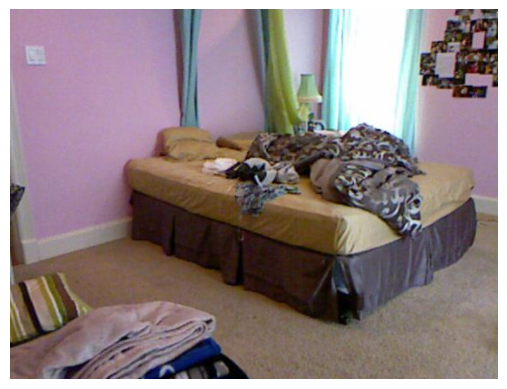

Q: what is the object on the shelves
GT: cup
Model: Question: what is the object on the shelves
Answer: a bed



In [13]:
run_example(0)

In [14]:
def extract_answer(text: str) -> str:
    text = str(text)
    if "Answer:" in text:
        return text.split("Answer:", 1)[1].strip()
    return text.strip()

In [15]:
def run_example(idx: int = 0):
    row = df.iloc[idx]

    img_path = get_image_path(row[IMAGE_COL])
    print("Image path:", img_path)

    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    question = str(row[QUESTION_COL])
    gt_answer = str(row[ANSWER_COL])

    prompt = f"Question: {question}\nAnswer:"
    raw_pred = wrapper.generate(image, prompt=prompt, max_new_tokens=20)
    pred_answer = extract_answer(raw_pred)

    print("Q :", question)
    print("GT:", gt_answer)
    print("Model(raw):", raw_pred)
    print("Model(ans):", pred_answer)

Image path: /root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1/dataset/images/image1009.png


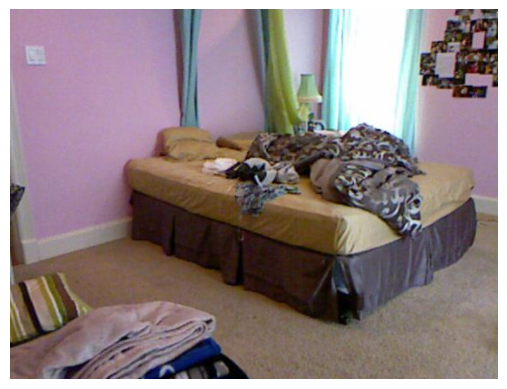

Q : what is the object on the shelves
GT: cup
Model(raw): Question: what is the object on the shelves
Answer: a bed

Model(ans): a bed


In [16]:
run_example(0)

In [17]:
import random
import pandas as pd

def eval_random_samples(n: int = 50, seed: int = 42) -> pd.DataFrame:
    random.seed(seed)
    indices = random.sample(range(len(df)), n)

    records = []

    for idx in indices:
        row = df.iloc[idx]
        img_path = get_image_path(row[IMAGE_COL])
        image = Image.open(img_path).convert("RGB")

        question = str(row[QUESTION_COL])
        gt_answer = str(row[ANSWER_COL])

        prompt = f"Question: {question}\nAnswer:"
        raw_pred = wrapper.generate(image, prompt=prompt, max_new_tokens=20)
        pred_answer = extract_answer(raw_pred)

        gt_norm = gt_answer.lower().strip()
        pred_norm = pred_answer.lower().strip()

        correct = gt_norm in pred_norm

        records.append({
            "idx": idx,
            "image_path": img_path,
            "question": question,
            "gt": gt_answer,
            "pred_raw": raw_pred,
            "pred": pred_answer,
            "correct": correct,
        })

    return pd.DataFrame(records)


In [18]:
results = eval_random_samples(n=50)
results.head()


,idx,image_path,question,gt,pred_raw,pred,correct
0,1824,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is under the stove,oven,Question: what is under the stove\nAnswer: a m...,a microwave,False
1,409,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is the edible object kept on the trays,bread,Question: what is the edible object kept on th...,a small bowl of fruit,False
2,4506,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is found in front of the lamp,bed,Question: what is found in front of the lamp\n...,a bed,True
3,4012,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is the purple box the brown table,tissue_box,Question: what is the purple box the brown tab...,the purple box is the table,False
4,3657,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is on the left side of the refrigerator,oven,Question: what is on the left side of the refr...,a refrigerator,False


In [19]:
acc = results["correct"].mean()
print(f"Accuracy (substring match 기준): {acc:.3f}")

results[~results["correct"]].head(10)


Accuracy (substring match 기준): 0.100


,idx,image_path,question,gt,pred_raw,pred,correct
0,1824,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is under the stove,oven,Question: what is under the stove\nAnswer: a m...,a microwave,False
1,409,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is the edible object kept on the trays,bread,Question: what is the edible object kept on th...,a small bowl of fruit,False
3,4012,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is the purple box the brown table,tissue_box,Question: what is the purple box the brown tab...,the purple box is the table,False
4,3657,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is on the left side of the refrigerator,oven,Question: what is on the left side of the refr...,a refrigerator,False
7,8935,/root/.cache/kagglehub/datasets/bhavikardeshna...,how many dark brown chairs are there,8,Question: how many dark brown chairs are there...,there are six,False
8,1424,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is to the left of the bed,cloth_drying_stand,Question: what is to the left of the bed\nAnsw...,a bed,False
9,9674,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is kept on the floor to the left side,garbage_bin,Question: what is kept on the floor to the lef...,a lot of stuff,False
10,6912,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is on the right side of the night stand,cables,Question: what is on the right side of the nig...,a night stand,False
11,520,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is on the chair back behind the counter,jacket,Question: what is on the chair back behind the...,a chair,False
12,488,/root/.cache/kagglehub/datasets/bhavikardeshna...,what is left of chair,window,Question: what is left of chair\nAnswer: the c...,the chair is gone,False
